# The transient universe


### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (10 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 




## Part 1: Emcee usage

In [1]:
import emcee
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

First I load the data from the data file:

In [2]:
filename = "../solutions/transient.npy"

In [3]:
data = np.load(filename)

In [4]:
times = np.array(data[:, 0])
flux = np.array(data[:, 1])
err_flux = np.array(data[:, 2])

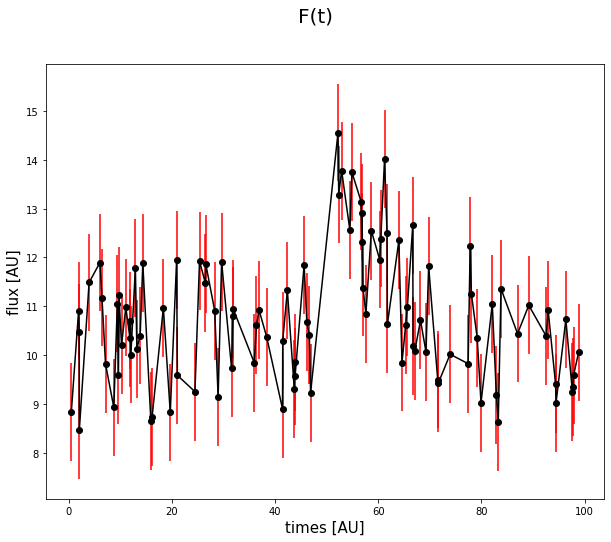

In [5]:
plt.figure(figsize=(10, 8))
plt.errorbar(times, flux, err_flux, c='k', ecolor='red', marker='o')
plt.xlabel("times [AU]", size=15)
plt.ylabel("flux [AU]", size=15)
plt.suptitle("F(t)", size=20);

# simple eyeballing of the INITIAL GUESSES (not prior) 
#myt=np.linspace(0,100,100)
#mym =Model([10,5,50,-2], myt)
#plt.plot(myt,mym)

In [6]:
# bayes theorem ingredients: 
    
def Model(par, t):
    
    b, A, t0, alpha = par
    
    model = []
    
    for i in range(0, len(t)): 
    
        if t[i] < t0:
        
            model.append(b)
    
        if t[i] >= t0:
        
            model.append(b + A * np.exp(- alpha * (t[i] - t0)))
            
    return model


def log_Prior(par):
    
    b, A, t0, alpha = par
    
    if b < 0 or b > 50 or A < 0 or A > 50 or t0 < 0 or t0 > 100 or alpha < 1e-5 or alpha > 1e5: 
        return -np.inf
    
    else:
        return -np.log(50 * 50 * 100 * np.log(1e5/1e-5) * alpha) 
    

def log_Likelihood(par, times, flux, err_flux):
    
    model = Model(par, times)
    
    return - 0.5 * np.sum(np.log(2*np.pi*err_flux**2) + ((flux - model) / err_flux)**2)

def log_Posterior (par, times, flux, err_flux):
    
    lp = log_Prior(par)
    
    if np.isfinite(lp):
        return lp + log_Likelihood(par, times, flux, err_flux)
    
    else:
        return lp

I use $\textit{emcee}$ to sample the posterior: 

In [7]:
ndim = 4  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nsteps = 100000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses =  np.array([10,5,50,1e-2]) + 1e-2 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_Posterior, args=(times, flux, err_flux))
sampler.run_mcmc(starting_guesses, nsteps, progress=True);

100%|██████████████████████████████████| 100000/100000 [04:37<00:00, 359.90it/s]


I then show the complete $\textit{traceplots}$ for each parameter: 

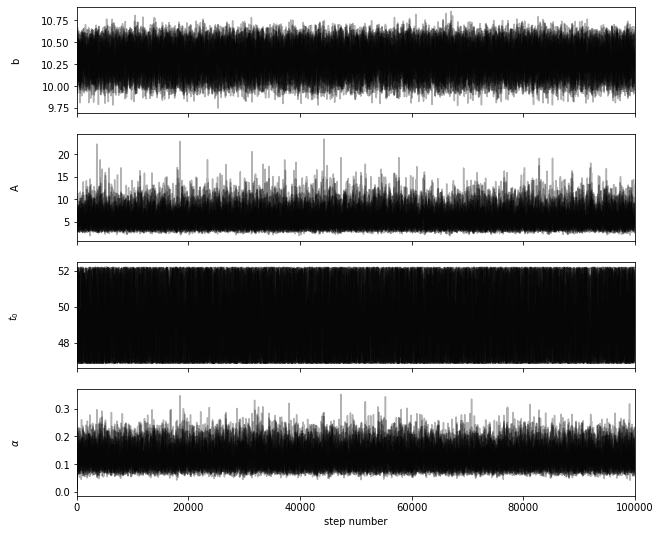

In [8]:
fig, axes = plt.subplots(4, figsize=(10, 9), sharex=True)

samples = sampler.get_chain()

labels = ["b", "A", r"$t_0$", r"$\alpha$"]

for i in range(0, ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], c="k", alpha=0.3)
    ax.set_xlim(0, 100000)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

And evaluate the $\textit{autocorrelation time}$ and select the one to thin the chain accordingly: 

In [9]:
tau = sampler.get_autocorr_time()
print(tau)

[68.19357664 93.04762744 91.9369333  78.18852584]


Setting the $\textit{burn}$ parameter (my choice): 

In [10]:
burn = 1000  # "burn-in" period to let chains stabilize

In [11]:
flat_samples = sampler.get_chain(discard=burn, thin=int(np.max(tau)), flat=True) 
# choose the max of autocorrelation 
#time as thinning


print(flat_samples.shape)

(10640, 4)


I show the results of the sampling by corner plots: 

In [12]:
import corner
import emcee
import time

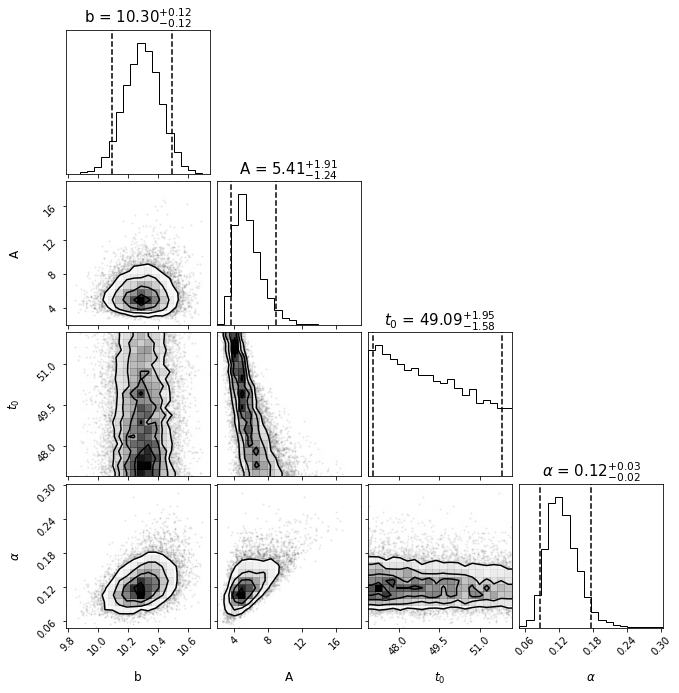

In [13]:
fig = corner.corner(
    flat_samples, labels=["b", "A", r"$t_0$", r"$\alpha$"], quantiles=[0.05, 0.95], show_titles=True, title_kwargs={"fontsize": 15}, label_kwargs=dict(fontsize=12)
);

I now try to do some statistics on the parameters: I will extract the $\textit{median}$ and $\textit{credibility regions}$ and print them nicely.

In [14]:
from IPython.display import display, Math, Latex

labels_output = ["b", "A", "t_0", r"\alpha"]

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])  # median is 50 percentile
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_output[i])

    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Let's now see how the posterior spread of model solutions that are consistent with the data. I will choose $100$ samples randomly from the burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data.

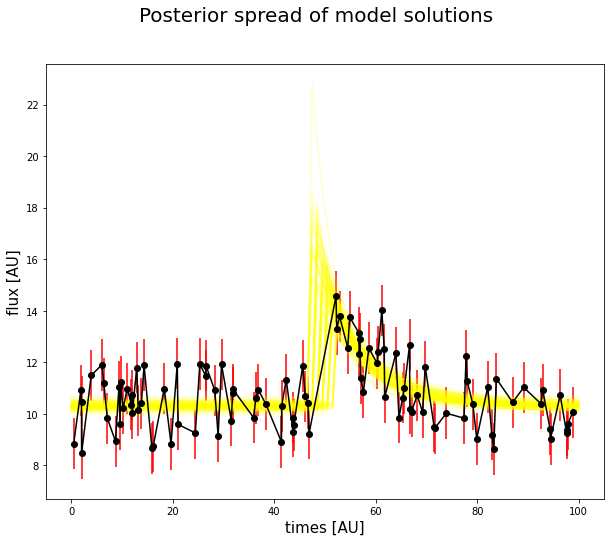

In [15]:
times_plot = np.linspace(0,100,100)

#plot section:

plt.figure(figsize=(10, 8))
plt.errorbar(times, flux, err_flux, marker='o', c="k", ecolor='red')
plt.xlabel("times [AU]", size=15)
plt.ylabel("flux [AU]", size=15)
plt.suptitle("Posterior spread of model solutions", size=20);


for i in range(0, 100): 
    
    chosen_post = int(stats.uniform.rvs(0, len(flat_samples)))
    my_Model = Model(flat_samples[chosen_post], times_plot)
    
    plt.plot(times_plot, my_Model, alpha=0.2, c='yellow')

## Part 2: Nested sampling and model comparison

8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

## Part 2.1: Nested sampling

In [16]:
import dynesty

In [17]:
# Define the dimensionality of the problem
ndim = 4

#define the TRANSFORM for the uniform prior (here uniform):

def ptform(theta):
    
    b, A, t0, alpha = theta # unpack the parameters

    return (stats.uniform.ppf(b, 0, 50), stats.uniform.ppf(A, 0, 50), stats.uniform.ppf(t0, 0, 100), stats.loguniform.ppf(alpha, 1e-5, 1e5))
def loglikelihood_dynesty(theta):
    """
    The log-likelihood function.
    """
    return - 0.5 * np.sum(np.log(2*np.pi*err_flux**2) + ((flux - Model(theta, times)) / err_flux)**2)

Note that I am using the same Model I defined in "Part1: Emcee usage". 

I now ask my sampler to evaluate the $\textit{evidence}$ I am interested in:

In [18]:
sampler = dynesty.NestedSampler(loglikelihood_dynesty, ptform, ndim, nlive=1000)
sampler.run_nested()
sresults = sampler.results

15428it [32:02,  8.02it/s, +1000 | bound: 634 | nc: 1 | ncall: 1168425 | eff(%):  1.407 | loglstar:   -inf < -140.666 <    inf | logz: -155.993 +/-  0.127 | dlogz:  0.001 >  1.009]


Log the results and print them: 

In [19]:
logZdynesty = sresults.logz[-1]        # value of logZ
logZerrdynesty = sresults.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

In [20]:
print('Marginalised evidence (using static sampler) is {} ± {}'.format(logZdynesty, logZerrdynesty))

Marginalised evidence (using static sampler) is -155.99317203173237 ± 0.2900680179456565


I then plot the parameters traces and 1-D marginalized posteriors. On the left panels, I see that the live points started out scattered across the prior volume, then move inwards as the sampler climbs the likelihood. The points have different weights, as highlighted in the documentation, due to importance weight.

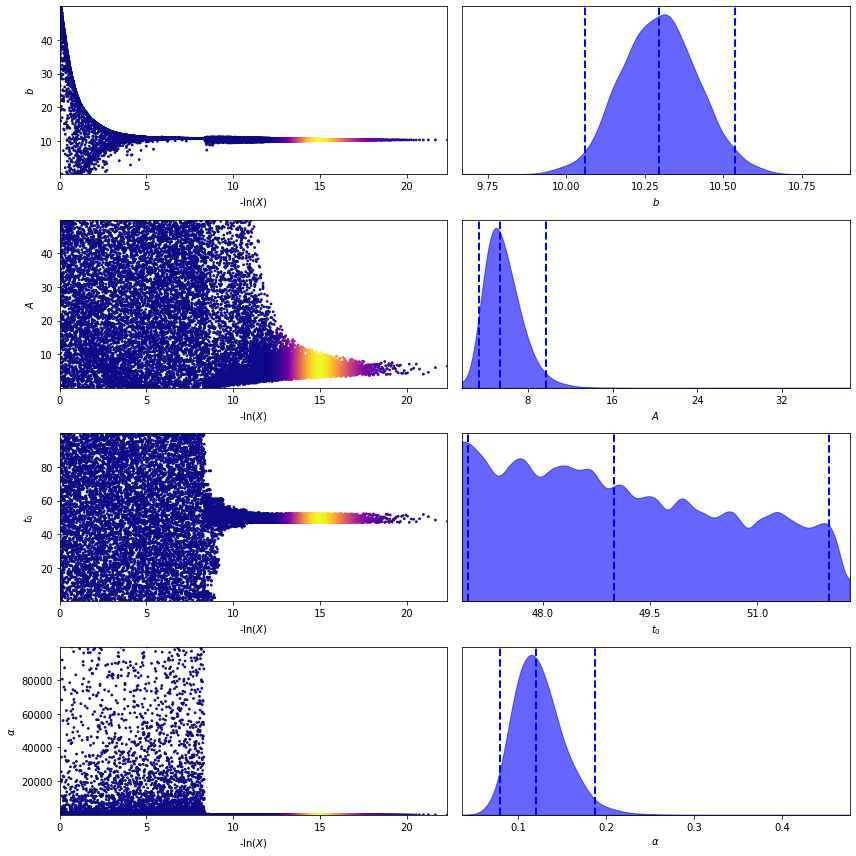

In [21]:
from dynesty import plotting as dyplot
tfig, taxes = dyplot.traceplot(sresults, trace_cmap='plasma', trace_color=None)

taxes[0][0].set_xlabel("-$\\ln(X)$")
taxes[0][0].set_ylabel("$b$")
taxes[0][1].set_xlabel("$b$")


taxes[1][0].set_xlabel("-$\\ln(X)$")
taxes[1][0].set_ylabel("$A$")
taxes[1][1].set_xlabel("$A$")


taxes[2][0].set_xlabel("-$\\ln(X)$")
taxes[2][0].set_ylabel("$t_0$")
taxes[2][1].set_xlabel("$t_0$")

taxes[3][0].set_xlabel("-$\\ln(X)$")
taxes[3][0].set_ylabel(r"$\alpha$")
taxes[3][1].set_xlabel(r"$\alpha$")


tfig.tight_layout()

Now I get the posterior samples: 

In [22]:
from dynesty.utils import resample_equal

In [23]:
weights = np.exp(sresults['logwt'] - sresults['logz'][-1])
postsamples = resample_equal(sresults.samples, weights)

In [24]:
print('Number of posterior samples (using static sampler) is {}'.format(postsamples.shape[0]))

Number of posterior samples (using static sampler) is 16428


And print the results using the corner module:

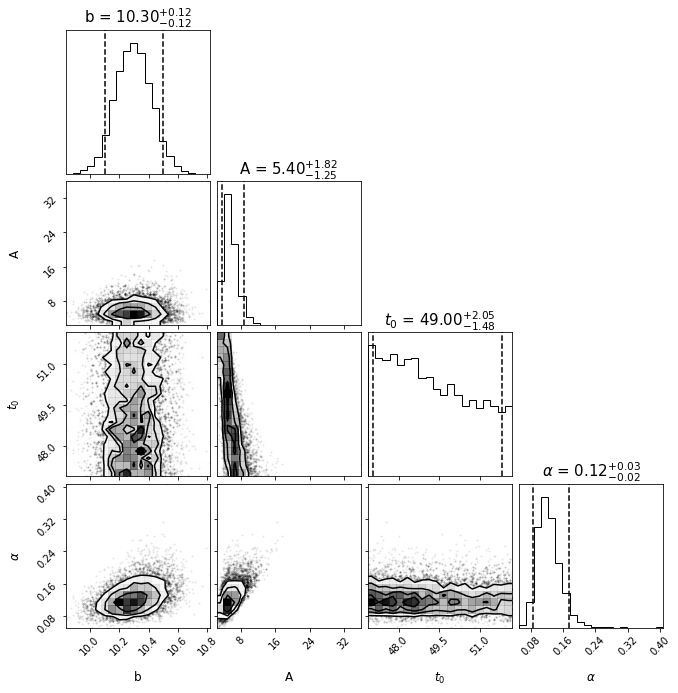

In [25]:
fig = corner.corner(
    postsamples, labels=labels, quantiles=[0.05, 0.95], show_titles=True, title_kwargs={"fontsize": 15}, label_kwargs=dict(fontsize=12)
);

Again, I am showing the results nicely and comparing them to the ones obtained through $\textit{emcee}$. 

In [26]:
labels_output = ["b", "A", "t_0", r"\alpha"]

for i in range(ndim):
    mcmc = np.percentile(postsamples[:, i], [5, 50, 95])  # median is 50 percentile
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_output[i])

    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

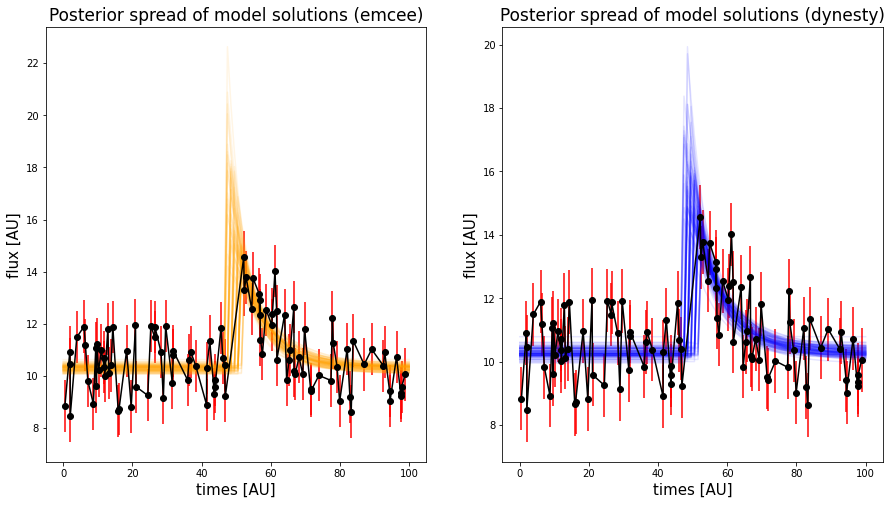

In [27]:
times_plot = np.linspace(0,100,100)

#plot section:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

ax1.errorbar(times, flux, err_flux, marker='o', c="k", ecolor='red')
ax1.set_xlabel("times [AU]", size=15)
ax1.set_ylabel("flux [AU]", size=15)
ax1.set_title("Posterior spread of model solutions (emcee)", size=17)

ax2.errorbar(times, flux, err_flux, marker='o', c="k", ecolor='red')
ax2.set_xlabel("times [AU]", size=15)
ax2.set_ylabel("flux [AU]",size=15)
ax2.set_title("Posterior spread of model solutions (dynesty)",size=17);


for i in range(0, 100): 
    
    chosen_post_2 = int(stats.uniform.rvs(0, len(postsamples)))
    my_nested_Model = Model(postsamples[chosen_post_2], times_plot)
    
    chosen_post = int(stats.uniform.rvs(0, len(flat_samples)))
    my_Model = Model(flat_samples[chosen_post], times_plot)
    
    ax1.plot(times_plot, my_Model, alpha=0.1, c='orange')
    ax2.plot(times_plot, my_nested_Model, alpha=0.1, c='blue')

## Part 2.2: Model comparison

Now I change the model and try to compare the two as we learned from the previous lectures: 

In [28]:
def Model_2(par, t):
    
    b, A, t0, sigma_w = par
    
    model = b + A * np.exp(-(t - t0)**2 / (2 * sigma_w**2))
            
    return model

def ptform_2(theta):
    
    b, A, t0, sigma_w = theta # unpack the parameters
    
    # set the transform for each parameter in (0, 1):
    
    return (stats.uniform.ppf(b, 0, 50), stats.uniform.ppf(A, 0, 50), stats.uniform.ppf(t0, 0, 100), stats.loguniform.ppf(sigma_w, 1e-4, 1e4))


def loglikelihood_dynesty_2(theta):  # define a second model and test it through this likelihood 
    """
    The log-likelihood function.
    """

    return - 0.5 * np.sum(np.log(2*np.pi*err_flux**2) + ((flux - Model_2(theta, times)) / err_flux)**2)

I again calculate the $\textit{evidence}$: 

In [29]:
sampler_2 = dynesty.NestedSampler(loglikelihood_dynesty_2, ptform_2, ndim)
sampler_2.run_nested()
sresults_2 = sampler_2.results

8903it [09:23, 15.80it/s, +500 | bound: 489 | nc: 1 | ncall: 428992 | eff(%):  2.194 | loglstar:   -inf < -144.311 <    inf | logz: -161.381 +/-  0.184 | dlogz:  0.001 >  0.509]


Load and print the result: 

In [30]:
logZdynesty_2 = sresults_2.logz[-1]        # value of logZ
logZerrdynesty_2 = sresults_2.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

In [31]:
print('Marginalised evidence (using static sampler) is {} ± {}'.format(logZdynesty_2, logZerrdynesty_2))

Marginalised evidence (using static sampler) is -161.38090226495223 ± 0.31710694706989995


Plot parameter traces and 1-D marginalized posteriors. 

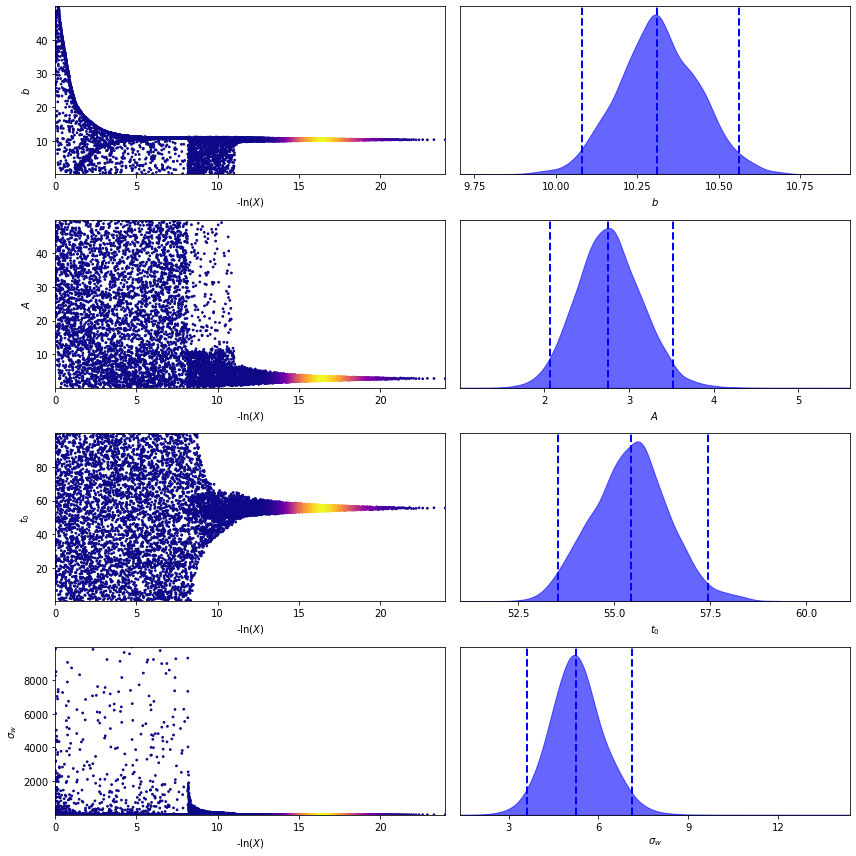

In [32]:
tfig_2, taxes_2 = dyplot.traceplot(sresults_2)

taxes_2[0][0].set_xlabel("-$\\ln(X)$")
taxes_2[0][0].set_ylabel("$b$")
taxes_2[0][1].set_xlabel("$b$")


taxes_2[1][0].set_xlabel("-$\\ln(X)$")
taxes_2[1][0].set_ylabel("$A$")
taxes_2[1][1].set_xlabel("$A$")


taxes_2[2][0].set_xlabel("-$\\ln(X)$")
taxes_2[2][0].set_ylabel("$t_0$")
taxes_2[2][1].set_xlabel("$t_0$")

taxes_2[3][0].set_xlabel("-$\\ln(X)$")
taxes_2[3][0].set_ylabel(r"$\sigma_w$")
taxes_2[3][1].set_xlabel(r"$\sigma_w$")


tfig_2.tight_layout()

Again, I want get the posterior samples:

In [33]:
weights_2 = np.exp(sresults_2['logwt'] - sresults_2['logz'][-1])
postsamples_2 = resample_equal(sresults_2.samples, weights_2)

In [34]:
print('Number of posterior samples (using static sampler) is {}'.format(postsamples_2.shape[0]))

Number of posterior samples (using static sampler) is 9403


Plot the results via corner:

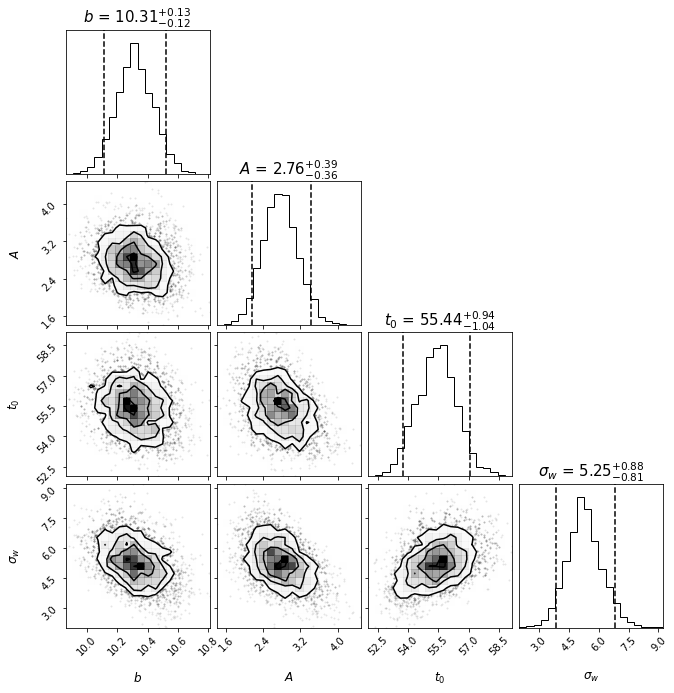

In [35]:
fig = corner.corner(
    postsamples_2, labels=[r"$b$", r"$A$", r"$t_0$", r"$\sigma_w$"], quantiles=[0.05, 0.95], show_titles=True, title_kwargs={"fontsize": 15}, label_kwargs=dict(fontsize=12) 
);

In this case all the parameters seem to be uncorrelated.
I now plot the results for models 1 and 2, obtained via $\textit{dynesty}$: 

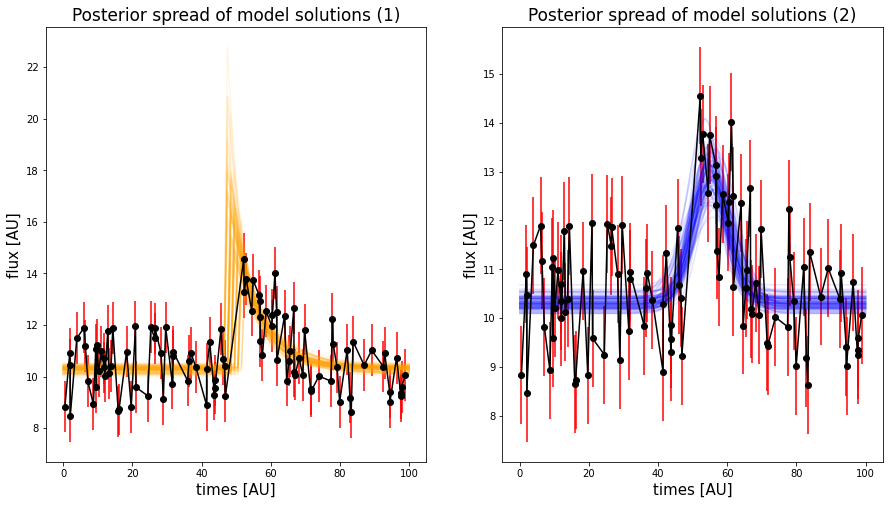

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

ax1.errorbar(times, flux, err_flux, marker='o', c="k", ecolor='red')
ax1.set_xlabel("times [AU]", size=15)
ax1.set_ylabel("flux [AU]", size=15)
ax1.set_title("Posterior spread of model solutions (1)", size=17)

ax2.errorbar(times, flux, err_flux, marker='o', c="k", ecolor='red')
ax2.set_xlabel("times [AU]", size=15)
ax2.set_ylabel("flux [AU]",size=15)
ax2.set_title("Posterior spread of model solutions (2)",size=17);

for i in range(0, 100): 
    
    chosen_post_2 = int(stats.uniform.rvs(0, len(postsamples)))
    my_nested_Model = Model(postsamples[chosen_post_2], times_plot)
    
    chosen_post_3 = int(stats.uniform.rvs(0, len(postsamples_2)))
    my_nested_Model_3 = Model_2(postsamples_2[chosen_post_3], times_plot)
    
    ax1.plot(times_plot, my_nested_Model, alpha=0.1, c='orange')
    ax2.plot(times_plot, my_nested_Model_3, alpha=0.1, c='blue')

Which model is the best?

To compute the $\textit{Odds fraction}$ we use this formula: 

$$O_{1,2} = B_{1, 2} \cdot \frac{\Pi(\Theta_{2})}{\Pi(\Theta_{2})}$$

where $B_{1, 2}$ is the $\textit{Bayes factor}$ (ratio between the two evidences), $\Pi(\Theta_{1})$ and $\Pi(\Theta_{2})$ are the prior knowledge I might have on the two models. This is important when we are mostly sure about one model with respect to the other, and we test them anyway to see if model 2 provides as well a good description of data. I don't know much about the underlying process of data acquiring nor the physics beyond this type of event, so I chose to keep the prior fraction $= 1$. This way, the evidence ratio only (Bayes factor) will provide the hint on the best model.

In [37]:
B_12 = np.exp(logZdynesty) / np.exp(logZdynesty_2)

In [38]:
print("Bayesian factor:", B_12)

Bayesian factor: 218.70640921488334


It is evident from this ratio that model 1 is better to describe data. However, as I carried out many tests on the prior knowledge, I found it interesting how the prior knowledge affects the physics you do with your data, and the best model to adapt based on that. 